In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.analysis import analysis
from quetzal.engine.pathfinder import PublicPathFinder
from quetzal.io.display import all_pt_paths
from syspy.skims import skims
from quetzal.engine import engine
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the PT network
## Needs aggregated PT networks

In [3]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Create a path for scenario-specific model files
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [5]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [6]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')
aux = stepmodel.read_json(model_path + 'de_pt_network_ancillary')

In [7]:
sm.centroids = ae.centroids
sm.footpaths = ae.footpaths
sm.zone_to_transit = ae.zone_to_transit

In [8]:
sm.links.shape

(403656, 10)

### Prepare links for pathfinder

Headways are relevant for the pathfinder in order to determine optimal interchange patterns. The waiting time (= half the headway) at the initial boarding station will be substracted from the route time. Instead, a constant "wait at station" time is added to access links. This does not depend on the itinerary, but only on travel behaviour and perception.

In [9]:
# aggregate local bus and tram, underground, ferry, funicular
if 'subway' in sm.links['route_type'].unique():
    sm.links['route_type_disagg'] = sm.links['route_type'].copy()
    sm.links['route_type'] = sm.links['route_type'].replace(
        {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus'})
    sm.pt_route_types = list(sm.links['route_type'].unique())

In [10]:
# Route types without headway
sm.links.loc[sm.links['headway'].isna()].groupby('route_type').agg({'a': 'count'})

,a
route_type,


In [11]:
sm.links['headway'] = sm.links['headway'].fillna(2*3600)

In [12]:
# Minimum headways of each route
sm.links['headway_route'] = sm.links['route_id'].map(
    sm.links.groupby('route_id').agg({'headway': 'min'}).to_dict()['headway'])

array([[<AxesSubplot:title={'center':'headway_route'}>,
        <AxesSubplot:title={'center':'headway'}>]], dtype=object)

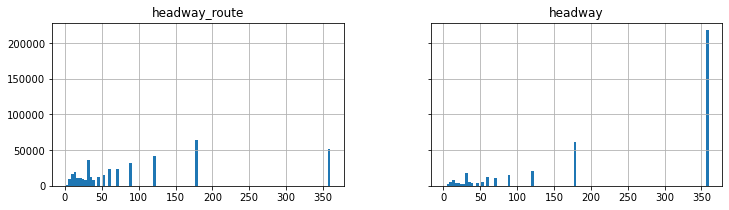

In [13]:
# Route headways seem to make route choice more reliable
(sm.links[['headway_route', 'headway']]/60/2).hist(bins=100, figsize=(12,3), sharey=True)

In [14]:
# Set a maximum headway in order to not confuse the pathfinder
urban_dict = sm.nodes['FID'].map(sm.zones['urbanisation'].to_dict()).to_dict()
for u in [1,2,3]:
    for mode in sm.pt_route_types:
        mask = (sm.links['route_type']==mode)&(sm.links['a'].map(urban_dict)==u)
        sm.links.loc[mask, 'headway'] = np.minimum(
            sm.links.loc[mask, 'headway_route'],
            params['max_headway_urban'+str(int(u))][mode])
#sm.links['headway'] = sm.links['headway_route']

In [15]:
sm.links['headway'] = sm.links['headway'].astype(int)

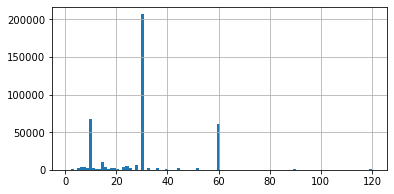

In [16]:
# Waiting time distribution in minutes
if manual: (sm.links['headway']/60/2).hist(bins=100, figsize=(6,3), log=False)

In [17]:
# Average waiting time
sm.links.groupby('route_type').agg({'headway': 'mean'})/60/2

,headway
route_type,
air,45.000000
bus,29.970167
coach,69.252825
rail_long,32.054820
rail_short,24.044080


In [18]:
# Set a mode-specific transfer penalty
# It will be substracted later
time_dict = params['transfer_penalty']
sm.links['boarding_time'] = sm.links['route_type'].map(time_dict) # in s

In [19]:
# Generate length for PT links
if 'length' not in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(sm.links['geometry']).astype(int)
    # Adjust coach transport towards road distances
    sm.links.loc[sm.links['route_type']=='coach', 'length'] *= 1.136

In [20]:
sm.links.sample()

,route_type,geometry,a,b,link_sequence,route_id,time,trip_id,headway,route_type_disagg,headway_route,boarding_time,length
index,,,,,,,,,,,,,
bus_1115372,bus,"LINESTRING (10.28431 48.25469, 10.25249 48.27018)",b_DE278_3_24,b_DE279_3_2,5,bus_17213,120,bus_17213_4,3600,bus,21600,0,2918.0


In [21]:
# Delete footpaths between centroids as they might confuse the pathfinder
# Add them later anew
sm.footpaths = sm.footpaths.loc[~((sm.footpaths['a'].isin(sm.centroids.index)) |
                                  (sm.footpaths['b'].isin(sm.centroids.index)) |
                                  (sm.footpaths['a']==sm.footpaths['b']))]

<AxesSubplot:>

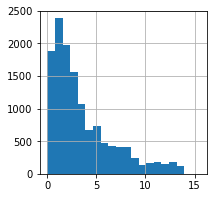

In [22]:
(sm.footpaths['time']/60).hist(bins=20, figsize=(3,3))

### Check zone_to_transit connectors

All zones need connectors

In [23]:
# Add missing connectors
ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids.loc[set(sm.zones.index) - set(sm.zone_to_transit['a'])],
    sm.nodes.loc[sm.nodes['route_type']=='bus'],
    short_leg_speed=params['pt_access']['speed_walk'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=1,
    coordinates_unit=sm.coordinates_unit)
sm.zone_to_transit = sm.zone_to_transit.append(
    ntlegs[set(sm.zone_to_transit.columns).intersection(ntlegs.columns)]
).reset_index(drop=True)

In [24]:
assert set(sm.zones.index) - set(sm.zone_to_transit['a']) == set()

In [25]:
# Add a initial waiting time for PT access legs
sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access', 'time'] += \
    params['access-egress_links']['time_pt']

### Apply PT pathfinder
It generates the LoS table with shortest paths for each origin destination pair

In [26]:
# We don't want the algorithm to search paths for all mode combinations.
# Thus, we have to extract the pathfinder and search them manually.
ppf = PublicPathFinder(sm)

In [31]:
# Now, build custom mode combinations to find paths for
# The combinations are modes that are NOT used in this path
#ppf.build_mode_combinations(mode_column='route_type')
all_types = set(sm.links['route_type'])
ppf.mode_combinations = [all_types - {t} for t in all_types] # single modes
ppf.mode_combinations.append(all_types) # just walking/cycling
ppf.mode_combinations.append(all_types - {'bus', 'rail_short'}) # short-distance only
ppf.mode_combinations.append(all_types - {'bus', 'rail_short', 'rail_long'}) # rail combo
ppf.mode_combinations.append(all_types - {'bus', 'coach'}) # road PT combo
ppf.mode_combinations.append(all_types - {'bus', 'rail_short', 'air'}) # air and local
ppf.mode_combinations

[{'air', 'coach', 'rail_long', 'rail_short'},
 {'air', 'bus', 'rail_long', 'rail_short'},
 {'air', 'bus', 'coach', 'rail_short'},
 {'bus', 'coach', 'rail_long', 'rail_short'},
 {'air', 'bus', 'coach', 'rail_long'},
 {'air', 'bus', 'coach', 'rail_long', 'rail_short'},
 {'air', 'coach', 'rail_long'},
 {'air', 'coach'},
 {'air', 'rail_long', 'rail_short'},
 {'coach', 'rail_long'}]

In [28]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

The volumes file is not (yet) available


In [32]:
# Run the pathfinder for all mode combinations
# If there is no boarding time column in links table:
# Include a transfer penalty in order to promote direct routes.
# It will be substracted later
# The penalty must be None, if a link boarding time is set
transfer_penalty = None
ppf.find_broken_mode_paths(cutoff=np.inf,
                           od_set=od_set,
                           mode_column='route_type',
                           boarding_time=transfer_penalty,
                           prune=False)

breaking modes: {'coach', 'rail_long'} : 100%|██████████████████████████████████████| 10/10 [2:03:48<00:00, 742.87s/it]


In [33]:
# Free some RAM
cols = ['origin', 'destination', 'path', 'gtime']
sm.pt_los = ppf.broken_mode_paths[cols]
ppf.broken_mode_paths = ppf.broken_mode_paths[cols]
ppf.zones = None
ppf.links = None
ppf.centroids = None
ppf.footpaths = None
ppf.ntlegs = None

In [34]:
# Drop inner-cell-connections
sm.pt_los = sm.pt_los.loc[sm.pt_los['origin']!=sm.pt_los['destination']]
print(sm.pt_los.shape)
sm.pt_los.sample()

(27271985, 4)


,origin,destination,path,gtime
1289457,DE246_10,DE80K_0,"[DE246_10, b_DE246_10_9, bus_2002414, bus_2002...",113116.023479


In [35]:
# Drop duplicate connections
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.pt_los.drop_duplicates('path', inplace=True)
sm.pt_los.reset_index(drop=True, inplace=True)
sm.pt_los.shape

(22599783, 4)

### Add attributes to LoS table

In [36]:
# Run the path analysis and assign paths as LoS table
sm.pt_los = analysis.path_analysis_od_matrix(
    od_matrix=sm.pt_los,
    links=sm.links,
    nodes=sm.nodes,
    centroids=sm.centroids)

path_analysis: 100%|█████████████████████████████████████████████████████| 22599783/22599783 [43:02<00:00, 8749.96it/s]


In [37]:
# Drop connections that don't move along links
# They usually take footpaths between stops to get to another zone
sm.pt_los = sm.pt_los.loc[sm.pt_los['link_path'].apply(lambda l: len(l)>0)]
sm.pt_los.shape

(22599673, 17)

In [38]:
# Add distances (Only path, not access/egress)
len_dict = sm.links['length'].to_dict()
sm.pt_los['length'] = sm.pt_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [39]:
# Disaggregate time into in-vehicle and access/egress
# Substract the transfer penalty set above (put 0)
if transfer_penalty is None:
    sm.analysis_pt_time(boarding_time=None)
    sm.pt_los['time'] -= sm.pt_los['boarding_time']
#    sm.pt_los['boarding_time'] = 0
else:
    sm.analysis_pt_time(boarding_time=0)
sm.pt_los.columns

Index(['origin', 'destination', 'path', 'gtime', 'boardings', 'alightings',
       'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers',
       'boarding_links', 'alighting_links', 'all_walk', 'ntransfers',
       'time_link_path', 'length_link_path', 'length', 'access_time',
       'footpath_time', 'in_vehicle_time', 'waiting_time', 'boarding_time',
       'time'],
      dtype='object')

In [40]:
# Substract the waiting time at the first stop
# for all modes but air (includes security checks etc.)
headway_dict = sm.links['headway'].to_dict()
mask = sm.pt_los['link_path'].apply(lambda l: l[0]).map(sm.links['route_type'].to_dict())!='air'
sm.pt_los.loc[mask, 'time'] -= sm.pt_los.loc[mask, 'link_path'].apply(
    lambda l: l[0]).map(headway_dict) / 2
sm.pt_los.loc[mask, 'waiting_time'] -= sm.pt_los.loc[mask, 'link_path'].apply(
    lambda l: l[0]).map(headway_dict) / 2

In [41]:
# Check times
sm.pt_los[['ntransfers', 'length']+[c for c in sm.pt_los.columns if c[-4:]=='time']].sample(2)

,ntransfers,length,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
8969216,3,290080.0,20499.139804,1408.639804,0.0,13320,4870.5,0,19599.139804
7657822,4,275992.0,19411.208568,1591.208568,0.0,11040,4980.0,0,17611.208568


In [42]:
# Add route_types
type_dict = sm.links['route_type'].to_dict()
sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                            for l in list(sm.pt_los['link_path'])]

In [43]:
# Add main route_type based on a hierarchy
hierarchy = ['air', 'coach', 'rail_long', 'rail_short', 'bus', 'walk']
def main_type(types):
    t = hierarchy[-1]
    try:
        t = hierarchy[min([hierarchy.index(t) for t in types])]
    except ValueError: # empty types set
        pass
    return t
sm.pt_los['route_type'] = sm.pt_los['route_types'].apply(main_type)

In [44]:
sm.pt_los.sample()

,origin,destination,path,gtime,boardings,alightings,node_path,link_path,footpaths,ntlegs,...,length_link_path,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_types,route_type
14185841,DE934_2,DEG09_2,"(DE934_2, b_DE934_2_0, bus_1489166, bus_148916...",22979.65914,"[b_DE934_2_0, rl_DE935_0_0, rs_DE91C_8_0, b_DE...","[b_DE935_0_106, rl_DE91C_8_0, rs_DEG09_0_0, b_...","[b_DE934_2_0, b_DE935_0_106, rl_DE935_0_0, rl_...","[bus_1489166, bus_1489167, bus_1489168, bus_14...","[(b_DE935_0_106, rl_DE935_0_0), (rl_DE91C_8_0,...","[(DE934_2, b_DE934_2_0), (b_DEG09_2_12, DEG09_2)]",...,317436.0,317436.0,1462.13661,217.52253,12300,5400.0,0,19379.65914,"{rail_short, bus, rail_long}",rail_long


In [ ]:
# Make a safety copy before restricting results
#if manual: los = sm.pt_los.copy()

In [ ]:
#sm.pt_los = los.copy()

### Clean PT LOS

In [47]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300_0')&(sm.pt_los['destination']=='DE600_0')][
    ['ntransfers', 'length', 'route_types', 'link_path']
    +[c for c in sm.pt_los.columns if c[-4:]=='time']]

,ntransfers,length,route_types,link_path,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
1858081,12,384953.000,{bus},"[bus_303689, bus_1716882, bus_1716884, bus_171...",38530.332989,1006.020929,79.312060,21046,15799.0,0,37930.332989
4772645,0,281094.112,{coach},[c_2330],14549.734895,989.734895,0.000000,11400,0.0,0,12389.734895
4869677,0,241407.000,{rail_long},[rl_1575],8355.782320,951.524195,24.258125,5580,0.0,0,6555.782320
5936835,0,257678.000,{rail_short},"[rs_22996, rs_22997, rs_22998, rs_22999, rs_23...",10813.101536,951.524195,21.577341,8040,0.0,0,9013.101536
13255350,0,241407.000,{rail_long},[rl_595],8355.782320,951.524195,24.258125,5580,0.0,0,6555.782320


In [48]:
# Keep only the fastest trip(s)
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple)
sm.pt_los = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_types']).nth(
        list(range(params['clean_los']['n_fastest_trips']))).reset_index()
sm.pt_los.shape

(19950490, 26)

In [49]:
# Drop trips with coach-rail or coach-air combinations
sm.pt_los = sm.pt_los.loc[~sm.pt_los['route_types'].apply(
    lambda x: 'coach' in x and ('rail_long' in x or 'rail_short' in x))]
sm.pt_los.shape

(19950490, 26)

In [50]:
'''# Drop trips with air interchange
sm.pt_los.drop(sm.pt_los.loc[(sm.pt_los['route_type']=='air') &
                             (sm.pt_los['link_path'].apply(
                                 lambda x: len([t for t in x if type_dict[t]=='air'])>1))
                            ].index, inplace=True)'''
sm.pt_los.shape

(19950490, 26)

In [51]:
# Drop unrealistically long trips
sm.pt_los = sm.pt_los.loc[sm.pt_los['in_vehicle_time']<params['clean_los']['max_duration']]
sm.pt_los.shape

(17246355, 26)

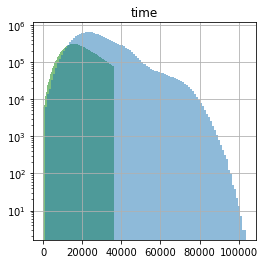

In [52]:
# Time distribution
if manual:
    sm.pt_los.hist(column='time', bins=100, log=True, alpha=.5,
                   ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                     bins=100, figsize=(4,4), log=True, alpha=.5))

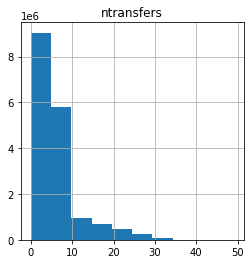

In [53]:
if manual: sm.pt_los.hist(column='ntransfers', figsize=(4,4))

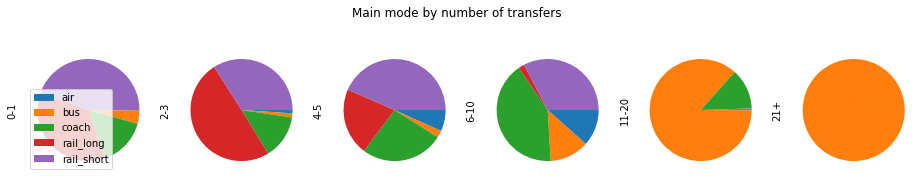

In [54]:
# Main mode distribution by transfers
if manual:
    t = sm.pt_los#.copy()
    t['bins'] = pd.cut(t['ntransfers'], bins=[0,1,3,5,10,20,100],
                       labels=["0-1", "2-3","4-5","6-10","11-20","21+"])
    axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
        subplots=True, figsize=(16, 3),
        startangle=0, counterclock=False, title='Main mode by number of transfers',
        legend=False, labeldistance=None)
    axs[0].legend(loc='lower left')

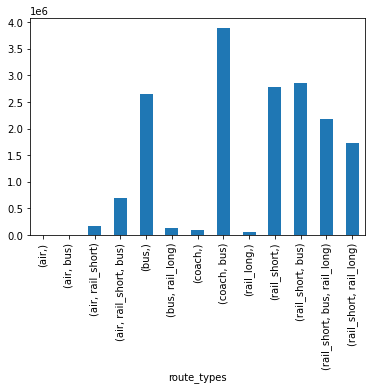

In [55]:
# Distribution of mode combinations
if manual:
    t.groupby('route_types').count()['route_type'].plot(kind='bar')

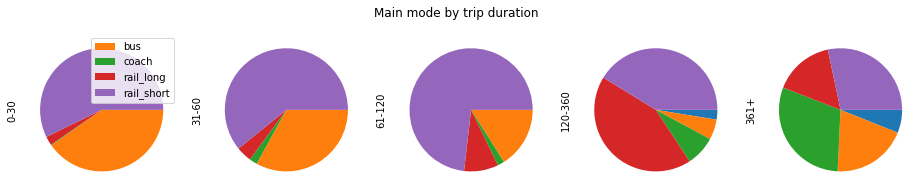

In [59]:
if manual:
    t['bins'] = pd.cut(t['time'], bins=[0,30*60,60*60,120*60,360*60,5000*60],
                       labels=["0-30","31-60","61-120","120-360","361+"])
    axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
        subplots=True, figsize=(16, 3),
        startangle=0, counterclock=False, title='Main mode by trip duration',
        legend=False, labeldistance=None)
    axs[0].legend()

In [60]:
# Drop unnecessary long connections if there is a waiting time applied
if sm.links['headway'].mean() > 1*60:
    sm.pt_los = sm.pt_los.loc[sm.pt_los['ntransfers']<=
                              params['clean_los']['max_transfers']]
    # Drop coach connections with more than one transfer
    sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                                (sm.pt_los['boardings'].apply(
                                    lambda l: len([n for n in l if n.startswith('c')])>2)
                                ))]
sm.pt_los.shape

(13472907, 27)

In [61]:
# Bus tickets are relatively cheap, but they apply only for short distances
# And nobody books tickets at five different bus agencies
# Thus, drop bus trips longer than 100km
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='bus') &
                            (sm.pt_los['length']>params['clean_los']['max_dist_bus']))]
sm.pt_los.shape

(13223373, 27)

In [62]:
# Also drop coach trips for local transport
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                            (sm.pt_los['length']<params['clean_los']['min_dist_coach']))]
sm.pt_los.shape

(13221200, 27)

In [63]:
# Keep only trips where in-vehicle-time makes at least a third
#sm.pt_los = sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3]
#sm.pt_los.shape
len(sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3])

13158930

In [70]:
# Drop rail short-distance trips above a distance threshold,
# if a long-distance connection is available
sm.pt_los['both'] = sm.pt_los.merge(
    sm.pt_los.groupby(['origin', 'destination'])['route_type'].apply(
        lambda od: 'rail_short' in list(od) and 'rail_long' in list(od)).rename('both'),
    left_on=['origin', 'destination'], right_index=True)['both']
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='rail_short') &
                            (sm.pt_los['both']==True) &
                            (sm.pt_los['length']>params['clean_los']['max_dist_rail_short']))]
sm.pt_los.drop('both', axis=1, inplace=True)
sm.pt_los.shape

(10377153, 27)

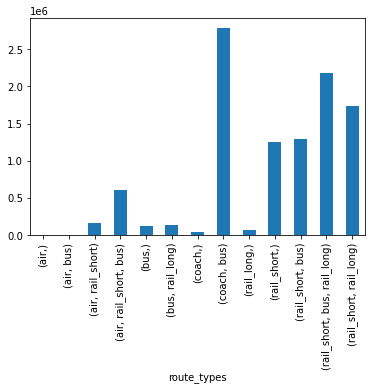

In [71]:
if manual: sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

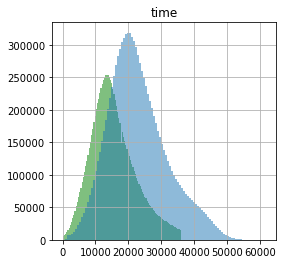

In [72]:
# Time distribution
if manual:
    sm.pt_los.hist(column='time', bins=100, log=False, alpha=.5,
                   ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                     bins=100, figsize=(4,4), log=False, alpha=.5))

In [73]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300_0')&(sm.pt_los['destination']=='DE600_0')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

,ntransfers,length,route_types,link_path,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
7822998,0,281094.112,"(coach,)",[c_2330],14549.734895,989.734895,0.000000,11400,0.0,0,12389.734895
7822999,0,241407.000,"(rail_long,)",[rl_1575],8355.782320,951.524195,24.258125,5580,0.0,0,6555.782320
7823000,0,257678.000,"(rail_short,)","[rs_22996, rs_22997, rs_22998, rs_22999, rs_23...",10813.101536,951.524195,21.577341,8040,0.0,0,9013.101536


In [74]:
# Stuttgart and surrounding?
sm.pt_los.loc[(sm.pt_los['origin']=='DE112_0')&(sm.pt_los['destination']=='DE111_0')]

,origin,destination,route_types,path,gtime,boardings,alightings,node_path,link_path,footpaths,...,length_link_path,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_type,bins
9372,DE112_0,DE111_0,"(bus,)","(DE112_0, rl_DE112_0_0, b_DE112_0_62, bus_1759...",2485.740450,"[b_DE112_0_62, b_DE112_0_28]","[b_DE112_0_28, b_DE111_0_201]","[rl_DE112_0_0, b_DE112_0_62, b_DE112_0_28, b_D...","[bus_1759823, bus_494386]","[(rl_DE112_0_0, b_DE112_0_62), (b_DE111_0_201,...",...,10759.0,10759.0,951.772976,114.467473,360,600.0,0,2026.240450,bus,31-60
9374,DE112_0,DE111_0,"(rail_long,)","(DE112_0, rl_DE112_0_0, rl_2829, rl_DE111_0_0,...",3975.299809,[rl_DE112_0_0],[rl_DE111_0_0],"[rl_DE112_0_0, rl_DE111_0_0]",[rl_2829],[],...,16857.0,16857.0,915.299809,0.000000,1260,0.0,0,2175.299809,rail_long,31-60
9375,DE112_0,DE111_0,"(rail_short,)","(DE112_0, rs_DE112_0_9, rs_39373, rs_39374, rs...",1888.992104,[rs_DE112_0_9],[rs_DE111_0_19],"[rs_DE112_0_9, rs_DE111_0_19, c_DE111_0_2]","[rs_39373, rs_39374]","[(rs_DE111_0_19, c_DE111_0_2)]",...,7857.0,7857.0,973.895298,95.096806,420,0.0,0,1488.992104,rail_short,0-30


In [68]:
print(len(sm.pt_los))
assert sm.pt_los.isna().any(axis=1).max() == 0

13221200


## Save model

In [75]:
# Ditch unneccessary columns
to_drop = ['gtime', 'path', 'reversed', 'pathfinder_session',
           'broken_modes', 'boardings', 'alightings', 'node_path',
           'footpaths', 'ntlegs', 'transfers', 'boarding_links',
           'alighting_links', 'all_walk', 'time_link_path',
           'length_link_path', 'boarding_time', 'index', 'bins']
sm.pt_los = sm.pt_los.drop(to_drop, axis=1, errors='ignore')

In [76]:
# Clean links table
to_drop = ['duration', 'cost', 'origin', 'destination']
sm.links = sm.links.drop(to_drop, axis=1, errors='ignore')

In [77]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'footpath_time',
        'waiting_time', 'length']
sm.pt_los[cols] = sm.pt_los[cols].astype(int)

In [78]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,time,route_type
3245513,DE21I_0,DE12C_2,"(rail_short, rail_long)","[rs_36709, rs_36710, rs_36711, rs_36712, rs_36...",3,252720,1506,0,12060,4200,17766,rail_long


In [79]:
# Saving LoS...
sm.to_json(model_path + 'de_pt_los',
           only_attributes=['pt_los'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 15/15 [02:28<00:00,  9.92s/it]
